In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os
import json

import optuna

os.environ["OPENPI_DATA_HOME"] = (
    "/mnt/virtual_ai0001071-01239_SR006-nfs2/apanasevich/openpi/assets"
)
os.environ["HF_HOME"] = "/mnt/virtual_ai0001071-01239_SR006-nfs2/.cache/huggingface"
os.environ["XDG_CACHE_HOME"] = "/mnt/virtual_ai0001071-01239_SR006-nfs2/.cache"

from lerobot.common.datasets.torch_transforms import compose
from lerobot.common.datasets.create_dataloader import create_lerobot_dataloader
from lerobot.common.datasets.data_config import (
    LeRobotAgibotTwoFingerDataConfig,
    LeRobotAgibotDexHandDataConfig,
)

from beast.bspline_tokenizer import BSpline_Tokenizer
import numpy as np

import hydra
from rich_argparse import RichHelpFormatter
from accelerate.utils import broadcast_object_list
import argparse

import torch
from lerobot.common.utils.inference_transforms import get_torch_input_transforms, get_torch_output_transforms
from accelerate.utils import InitProcessGroupKwargs
from datetime import timedelta

from lerobot.common.datasets.data_config import (
    AssetsConfig as LeRobotAssetsConfig
)
from lerobot.common.datasets.data_config import DataConfig as LeRobotBaseDataConfig
from lerobot.common.policies.pi0.configuration_pi0 import PI0Config
from lerobot.common.policies.pi0fast.configuration_pi0fast import PI0FASTConfig
from tqdm import tqdm
from accelerate import Accelerator
from lerobot.common.utils.normalize import RunningStats, save as save_stats
import torch.distributed as dist
from pathlib import Path
from omegaconf import OmegaConf, DictConfig

from hydra.utils import instantiate
from lerobot.common.datasets.create_dataloader import create_lerobot_dataset_by_config
from torch.utils.data import DataLoader

from typing import Any
import random
import logging

from functools import partial


def create_train_val_datasets_distributed(
    data_config_factory: Any,
    model_config: Any,
    assets_dirs: str,
    accelerator: Accelerator,  # Add accelerator parameter
    val_split: float = 0.1,
    seed: int = 42,
    map_to_unified_space: bool = False,
    use_validation_list: bool = False,
    recompute_norm_stats: bool = False,
    **dataset_kwargs
):
    """
    Create train and validation datasets with distributed-aware episode splitting.
    Only main process loads metadata, then broadcasts splits to all processes.
    
    Logic flow:
    1. First, check if validation episodes are provided in data config via 'validation_episodes' key
    2. If validation episodes files are found, load them and create val_episodes_dict from them
    3. If no validation episodes files are found, do random shuffling and splitting based on val_split ratio
    4. Train episodes are always created as the complement of validation episodes
    
    The validation_episodes JSON file can contain:
    - Direct list: [0, 1, 2, ...] (applies to all datasets)
    - Multi-dataset dict: {dataset_name: [0, 1, 2, ...]}
    """
    class DummyFactory:
        def __init__(self, cfg_item):
            self.cfg_item = cfg_item
        
        def create(self, *args, **kwargs):
            return self.cfg_item
    
    # Get data config to determine dataset type (needed for output pipeline creation)
    data_cfg = data_config_factory.create(assets_dirs, model_config)
    
    # Check if we have mixture configs
    if hasattr(data_cfg, 'mixture_configs') and data_cfg.mixture_configs:
        # Multi-dataset scenario
        dataset_configs = data_cfg.mixture_configs
        dataset_names = [cfg_item.repo_id for cfg_item in dataset_configs] 
        for i, cfg_item in enumerate(dataset_configs):
            cfg_name = dataset_names[i]
    else:
        # Single dataset scenario
        dataset_configs = [data_cfg]
        dataset_names = ["main"]
    
    # ONLY MAIN PROCESS loads metadata and creates splits
    if accelerator.is_main_process:
        train_episodes_dict = {}
        val_episodes_dict = {}
        # First, try to load validation episodes from data config
        validation_episodes_loaded = False
        
        for i, cfg_item in enumerate(dataset_configs):
            cfg_name = dataset_names[i]
            
            # Check if validation episodes are provided for this dataset
            if use_validation_list and hasattr(cfg_item, 'validation_episodes') and cfg_item.validation_episodes:
                validation_episodes_path = cfg_item.validation_episodes
                if os.path.exists(validation_episodes_path):
                    try:
                        with open(validation_episodes_path, 'r') as f:
                            validation_episodes_data = json.load(f)
                        
                        # Handle different JSON structures for this specific dataset
                        if isinstance(validation_episodes_data, list):
                            # Direct list format: [0, 1, 2, ...]
                            val_episodes_dict[cfg_name] = validation_episodes_data
                        elif isinstance(validation_episodes_data, dict):
                            # Multi-dataset format: {dataset_name: [episodes]}
                            if cfg_name in validation_episodes_data:
                                val_episodes_dict[cfg_name] = validation_episodes_data[cfg_name]
                            else:
                                # Fallback to random splitting for this dataset
                                val_episodes_dict[cfg_name] = None
                        else:
                            # Fallback to random splitting for this dataset
                            val_episodes_dict[cfg_name] = None
                        
                        if val_episodes_dict[cfg_name] is not None:
                            validation_episodes_loaded = True
                            logging.info(f"Loaded validation episodes for {cfg_name} from data config {validation_episodes_path}: {val_episodes_dict[cfg_name]}")
                        else:
                            logging.warning(f"Could not extract validation episodes for {cfg_name} from {validation_episodes_path}")
                    except Exception as e:
                        logging.warning(f"Failed to load validation episodes for {cfg_name} from {validation_episodes_path}: {e}")
                        val_episodes_dict[cfg_name] = None
                else:
                    logging.warning(f"Validation episodes file {validation_episodes_path} not found for {cfg_name}")
                    val_episodes_dict[cfg_name] = None
            else:
                val_episodes_dict[cfg_name] = None
        
        # If no validation episodes were loaded, do random splitting
        if not validation_episodes_loaded:
            logging.warning("No validation episodes files found or use_validation_list is False, using random splitting")
            for i, cfg_item in enumerate(dataset_configs):
                cfg_name = dataset_names[i]
                
                # Load metadata for this dataset
                info_path = Path(cfg_item.root_dir) / "meta" / "info.json"
                with open(info_path, "r") as f:
                    total_episodes = json.load(f)["total_episodes"]
                
                # Create random episode splits
                all_episodes = list(range(total_episodes))
                random.seed(seed + hash(cfg_name))
                random.shuffle(all_episodes)
                
                n_val = max(1, int(total_episodes * val_split))
                val_episodes = all_episodes[:n_val]
                train_episodes = all_episodes[n_val:]
                
                val_episodes_dict[cfg_name] = val_episodes
                train_episodes_dict[cfg_name] = train_episodes
        else:
            # Create train episodes as complement of validation episodes
            for i, cfg_item in enumerate(dataset_configs):
                cfg_name = dataset_names[i]
                
                # Load metadata for this dataset
                info_path = Path(cfg_item.root_dir) / "meta" / "info.json"
                with open(info_path, "r") as f:
                    total_episodes = json.load(f)["total_episodes"]
                
                if val_episodes_dict[cfg_name] is not None:
                    # Create train episodes as complement of validation episodes
                    all_episodes = set(range(total_episodes))
                    val_episodes_set = set(val_episodes_dict[cfg_name])
                    train_episodes = sorted(list(all_episodes - val_episodes_set))
                    train_episodes_dict[cfg_name] = train_episodes
                else:
                    # Fallback to random splitting for this dataset
                    all_episodes = list(range(total_episodes))
                    random.seed(seed + hash(cfg_name))
                    random.shuffle(all_episodes)
                    
                    n_val = max(1, int(total_episodes * val_split))
                    val_episodes = all_episodes[:n_val]
                    train_episodes = all_episodes[n_val:]
                    
                    val_episodes_dict[cfg_name] = val_episodes
                    train_episodes_dict[cfg_name] = train_episodes
    else:
        # Other processes wait for broadcast
        train_episodes_dict = None
        val_episodes_dict = None
    
    # BROADCAST episode splits from main process to all processes
    train_episodes_dict = broadcast_object_list([train_episodes_dict])[0]
    val_episodes_dict = broadcast_object_list([val_episodes_dict])[0]
    
    # Check if we have mixture configs (data_cfg already created above)
    is_mixture_cfg = hasattr(data_cfg, 'mixture_configs') and data_cfg.mixture_configs

    # If a dataset provides an episodes allowlist file, intersect BEFORE sharding to avoid empty subsets
    cfg_map = {}
    if is_mixture_cfg:
        for item in data_cfg.mixture_configs:
            cfg_map[item.repo_id] = item
    else:
        cfg_map["main"] = data_cfg

    allowed_by_cfg = {}
    for name, cfg_item in cfg_map.items():
        allowlist_path = getattr(cfg_item, 'episodes_list_file', None)
        allowed_set = None
        try:
            if allowlist_path and os.path.exists(allowlist_path):
                with open(allowlist_path, 'r') as f:
                    allowed_set = set(json.load(f))
        except Exception:
            allowed_set = None
        allowed_by_cfg[name] = allowed_set

    def _apply_allowlist(eps_dict: dict[str, list[int]]):
        out = {}
        for name, eps in eps_dict.items():
            allowed = allowed_by_cfg.get(name)
            if isinstance(eps, list) and allowed is not None:
                filtered = [e for e in eps if e in allowed]
                if len(filtered) == 0 and len(allowed) > 0:
                    # Fallback to all allowed episodes to avoid empty datasets
                    filtered = sorted(list(allowed))
                elif len(allowed) == 0:
                    raise Exception(f'The validation episodes are empty for the dataset: {name}. Please check the episodes list file: {allowlist_path} or the validation episodes list: meta/validation_episodes.json')
                out[name] = filtered
            else:
                out[name] = eps
        return out

    train_episodes_dict = _apply_allowlist(train_episodes_dict)
    val_episodes_dict = _apply_allowlist(val_episodes_dict)

    # Partition validation episodes across processes so each worker evaluates on a different subset
    # Keep keys identical across ranks to avoid collective mismatches during metric aggregation
    if hasattr(data_cfg, 'mixture_configs') and data_cfg.mixture_configs:
        world_size = accelerator.num_processes
        rank = accelerator.process_index
        val_episodes_dict_local = {}
        for cfg_name, eps in val_episodes_dict.items():
            if isinstance(eps, list):
                if len(eps) >= world_size:
                    # Round-robin sharding
                    shard = eps[rank::world_size]
                elif len(eps) > 0:
                    # Too few episodes for strict sharding; assign at least one per rank via wrap-around
                    shard = [eps[rank % len(eps)]]
                else:
                    shard = []
                val_episodes_dict_local[cfg_name] = shard
            else:
                # Fallback: if episodes are not a list, keep as-is
                val_episodes_dict_local[cfg_name] = eps
        
        
        # Shard training episodes across processes with safe fallback for tiny splits
        train_episodes_dict_local = {}
        for cfg_name, eps in train_episodes_dict.items():
            if isinstance(eps, list):
                if len(eps) >= world_size:
                    shard = eps[rank::world_size]
                elif len(eps) > 0:
                    shard = [eps[rank % len(eps)]]
                else:
                    shard = []
                train_episodes_dict_local[cfg_name] = shard
            else:
                train_episodes_dict_local[cfg_name] = eps
    else:
        train_episodes_dict_local = train_episodes_dict
        val_episodes_dict_local = val_episodes_dict


    # ALL PROCESSES create datasets using their local episode splits
    train_dataset, norm_stats = create_lerobot_dataset_by_config(
        data_config_factory=data_config_factory,
        model_config=model_config,
        assets_dirs=assets_dirs,
        episodes=train_episodes_dict_local,
        normalization_mode=model_config.normalization_mode,
        return_norm_stats=True,
        map_to_unified_space=map_to_unified_space,
        recompute_norm_stats=recompute_norm_stats,
        **dataset_kwargs
    )
    # If mixture dataset, set per-rank RNG to reduce cross-rank duplication
    if hasattr(train_dataset, "set_rng"):
        try:
            import numpy as _np
            train_dataset.set_rng(_np.random.RandomState(seed + rank))
        except Exception:
            pass
    
    val_datasets_dict = {}
    # data_cfg already created above, reuse it
    is_mixture = hasattr(data_cfg, 'mixture_configs') and data_cfg.mixture_configs
    
    # Initialize output_pipeline_dict for all processes
    output_pipeline_dict = {}
    
    for cfg_name, eps in val_episodes_dict_local.items():
        if is_mixture:
            cfg_item = next(item for item in data_cfg.mixture_configs if item.repo_id == cfg_name)
        else:
            cfg_item = data_cfg
        norm_stats_item = norm_stats[cfg_item.repo_id]
        factory = DummyFactory(cfg_item)
        val_dataset = create_lerobot_dataset_by_config(
            data_config_factory=factory,
            model_config=model_config,
            assets_dirs=assets_dirs,
            episodes=eps,
            normalization_mode=model_config.normalization_mode,
            return_norm_stats=False,
            recompute_norm_stats=False,
            precomputed_norm_stats=norm_stats,
            map_to_unified_space=map_to_unified_space,
            **dataset_kwargs
        )
        val_datasets_dict[cfg_name] = val_dataset
        output_pipeline_dict[cfg_name] = compose(
            get_torch_output_transforms(
                norm_stats=norm_stats_item,
                policy_config=model_config,
                data_config_factory=DummyFactory(cfg_item),
                assets_dirs=assets_dirs,
                normalization_mode=model_config.normalization_mode,
                map_to_unified_space=map_to_unified_space
        ))

    return train_dataset, val_datasets_dict, norm_stats, output_pipeline_dict

def instantiate_data_config(cfg: DictConfig, add_kwargs: dict = None):
    """Instantiate robotics dataset config.

    - For mixture configs: mutate each nested data_config only for keys that already exist
    (e.g., map_to_unified_space, map_to_humanoid), then instantiate with _recursive_=False.
    - For individual configs: set keys on the config if they already exist, then instantiate with _recursive_=True.
    """
    try:
        is_mixture = cfg._target_.split(".")[-1] == "MixtureDataConfigFactory"
    except Exception:
        is_mixture = False

    if is_mixture and hasattr(cfg, "datasets_with_weights") and cfg.datasets_with_weights is not None:
        assert cfg.data_configs is None, "both datasets_with_weights and data_configs are set"
        assert cfg.weights is None, "both datasets_with_weights and weights are set"
        datasets_list = [ds_cfg.path for ds_cfg in cfg.datasets_with_weights]
        weights_list = [ds_cfg.weight for ds_cfg in cfg.datasets_with_weights]
        cfg.data_configs = datasets_list
        cfg.weights = weights_list
        del cfg.datasets_with_weights

    if add_kwargs:
        if is_mixture and hasattr(cfg, "data_configs") and cfg.data_configs is not None:
            # Update only existing keys in each nested dataset cfg to avoid unknown-arg errors
            for idx in range(len(cfg.data_configs)):
                dc = cfg.data_configs[idx]
                try:
                    # DictConfig supports 'in' and item assignment
                    for k, v in add_kwargs.items():
                        if isinstance(dc, DictConfig):
                            if k in dc:
                                dc[k] = v
                        elif isinstance(dc, dict):
                            if k in dc:
                                dc[k] = v
                except Exception:
                    # Best-effort; skip problematic entries
                    pass
        else:
            # Individual dataset config: only set keys that exist in cfg
            for k, v in add_kwargs.items():
                try:
                    if k in cfg:
                        cfg[k] = v
                except Exception:
                    pass

    if is_mixture:
        return hydra.utils.instantiate(cfg, _recursive_=False)
    else:
        return hydra.utils.instantiate(cfg, _recursive_=True)

def get_datasets():
    try:
        OmegaConf.register_resolver(
            "_load_config", lambda rel_path: OmegaConf.load(os.path.join(os.getcwd(), rel_path))
        )
    except:
        pass

    accelerator = Accelerator()
    assets_dir = '/mnt/virtual_ai0001071-01239_SR006-nfs2/apanasevich/pi0_assets_v4'

    cfg = torch.load('config.ckpt', weights_only=False)
    cfg.robotics_dataset.data_configs = cfg.robotics_dataset.data_configs[:3]
    cfg.robotics_dataset.weights = cfg.robotics_dataset.weights[:3]

    map_to_unified_space = False
    map_to_humanoid = False
    add_kwargs = {
        'map_to_unified_space': map_to_unified_space,
        'map_to_humanoid': map_to_humanoid,
    }
    robotics_dataset_factory = instantiate_data_config(cfg.robotics_dataset, add_kwargs)
    policy_config = hydra.utils.instantiate(cfg.policy.policy_config)

    val_split = 0.02

    robotics_dataset, val_datasets_dict, norm_stats, output_pipeline_dict = create_train_val_datasets_distributed(
        data_config_factory=robotics_dataset_factory,
        model_config=policy_config,
        assets_dirs=assets_dir,
        accelerator=accelerator,
        val_split=val_split,
        seed=42,
        map_to_unified_space=map_to_unified_space,
        use_validation_list=True,
        recompute_norm_stats=False,
    )
    
    return robotics_dataset, val_datasets_dict, norm_stats, output_pipeline_dict

/home/jovyan/shares/SR006.nfs2/micromamba/envs/af_beast_calvin/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/mnt/virtual_ai0001071-01239_SR006-nfs2/afedorov/projects/constant_repos/lerobot-fork/lerobot/common/datasets/vlm_datasets/qwen_dataset_specific_augmentations.py:147: UserWarning: Argument(s) 'alpha_affine' are not valid for transform ElasticTransform
  A.ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=0.2),
/mnt/virtual_ai0001071-01239_SR006-nfs2/afedorov/projects/constant_repos/lerobot-fork/lerobot/common/datasets/vlm_datasets/qwen_dataset_specific_augmentations.py:149: UserWarning: Argument(s) 'shift_limit' are not valid for transform OpticalDistortion
  A.OpticalDistortion(distort_limit=0.05, shift_limit=0.05, p=0.2),
/home/jovyan/shares/SR006.nfs2/micromamba/envs/af_beast_calvin/lib

In [2]:
robotics_dataset, val_datasets_dict, norm_stats, output_pipeline_dict = get_datasets()

/tmp/ipykernel_1702370/3505235208.py:409: UserWarning: register_resolver() is deprecated.
See https://github.com/omry/omegaconf/issues/426 for migration instructions.

  OmegaConf.register_resolver(


Creating LeRobot dataset for repo_id: aloha_aij

filtering aloha_aij: 7308 -> 7308 episodes

Initialized PromptFromLeRobotTaskTorch with 1858 tasks.

map_to_unified_space: False

Creating LeRobot dataset for repo_id: rdt

filtering rdt: 6002 -> 6002 episodes

Initialized PromptFromLeRobotTaskTorch with 272 tasks.

map_to_unified_space: False

Creating LeRobot dataset for repo_id: biplay

filtering biplay: 5989 -> 5989 episodes

Initialized PromptFromLeRobotTaskTorch with 2441 tasks.

map_to_unified_space: False

Creating LeRobot dataset for repo_id: aloha_aij

filtering aloha_aij: 30 -> 30 episodes

Initialized PromptFromLeRobotTaskTorch with 1858 tasks.

map_to_unified_space: False

Creating LeRobot dataset for repo_id: rdt

filtering rdt: 30 -> 30 episodes

Initialized PromptFromLeRobotTaskTorch with 272 tasks.

map_to_unified_space: False

Creating LeRobot dataset for repo_id: biplay

filtering biplay: 30 -> 30 episodes

Initialized PromptFromLeRobotTaskTorch with 2441 tasks.

map_to_unified_space: False

In [3]:
dtl = DataLoader(robotics_dataset, batch_size=192, shuffle=True)

In [20]:
tokenizer = BSpline_Tokenizer(
    num_basis=15, 
    vocab_size=256,
    degree_p=0,
    gripper_zero_order=False,
    num_dof=7, 
    seq_len=10, 
    gripper_indices=[],
    init_pos=False,
    device='cpu'
)
# tokenizer.fit_parameters(dtl, max_samples=25)

actions = next(iter(dtl))['actions'][:, :, :7]

/tmp/ipykernel_1702370/2579925228.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[j].legend(loc="best")


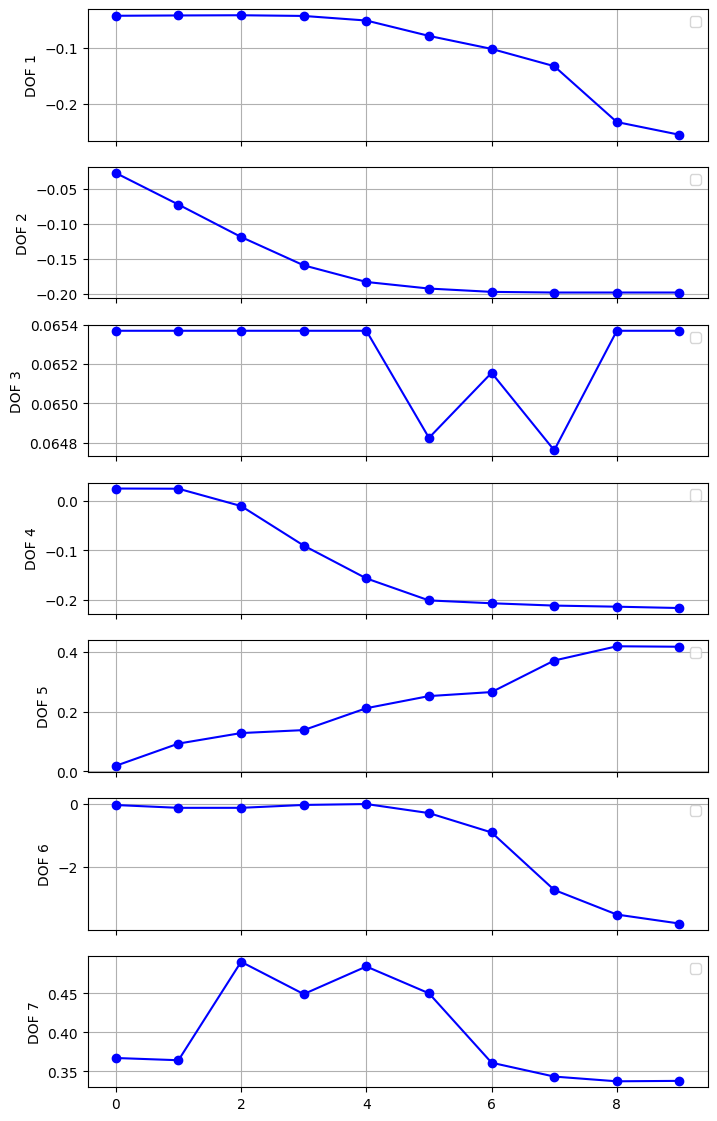

In [29]:
from matplotlib import pyplot as plt

for i in range(1):
    fig, axes = plt.subplots(7, 1, figsize=(8, 2 * 7), sharex=True)
    for j in range(7):
        axes[j].plot(actions[i, :, j], marker='o',  linestyle='-', color='b')
        axes[j].set_ylabel(f"DOF {j + 1}")
        axes[j].grid(True)
        axes[j].legend(loc="best")

plt.show()


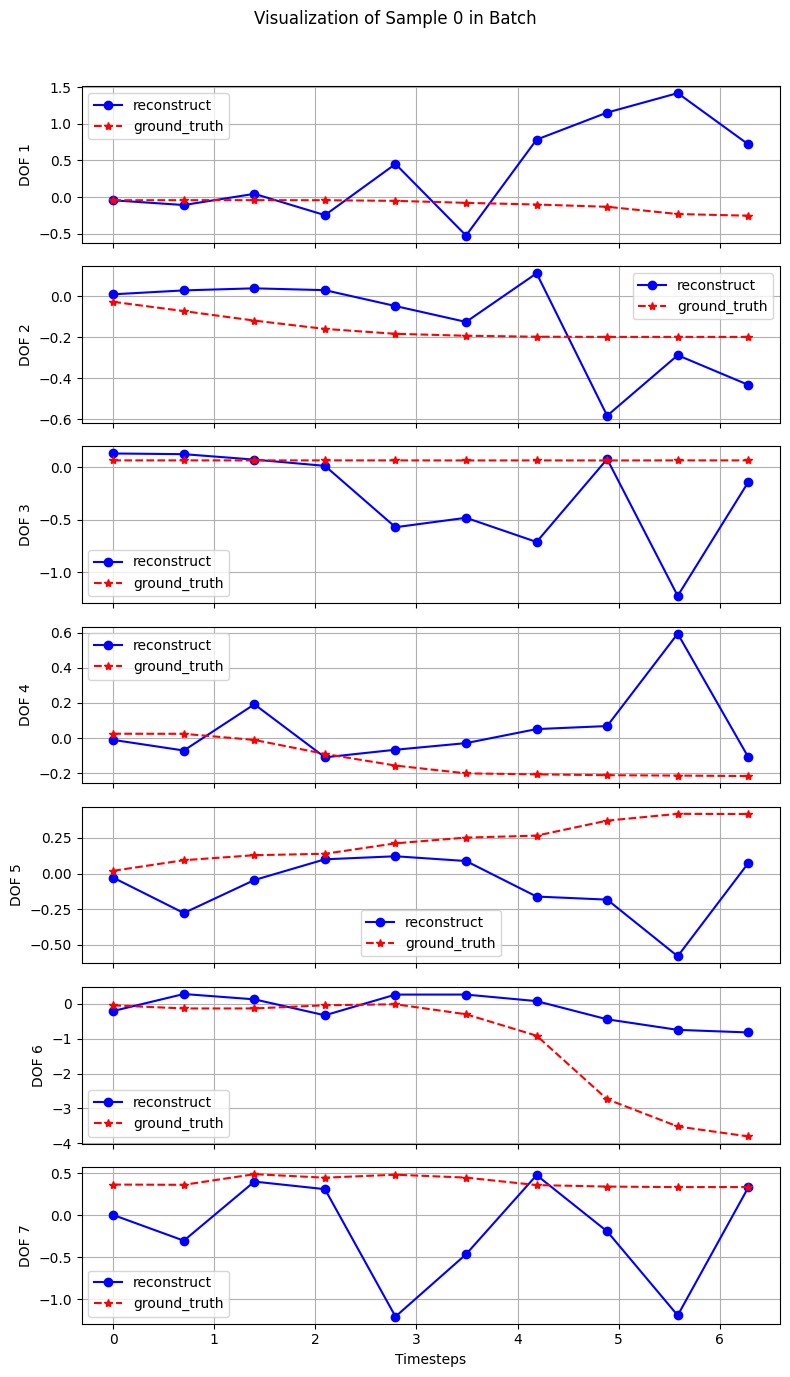

In [30]:
%matplotlib inline
tokenizer.visualize_reconstruction_error(actions[0])